<a href="https://colab.research.google.com/github/Xiaoyu-Su-20/Novartis-Hackathon/blob/main/Novartis_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we are going to build models for the data we prepared in the first notebook.

In [ ]:
import numpy as np
import pandas as pd
import datetime
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# read the data
df = pd.read_csv('/content/drive/My Drive/Novartis/obj2_data.csv')

We define our target as such:

1: Starting L2 treatment within 3 months.

2: Starting L2 treatment after 3 months.

The definition takes into account model performances and practicality.From a practical perspective, we might care more about patients that would pay a recent visit, and we care less about the the patients that would come 2 or 3 years later. Also, we think there is no need to 
distinguish between this week and that week, since there is already a lot of randomness to it. From a model performance perspective, models cannot learn finer categories. For example, our model can't tell
the difference between 6 months and a year. It could be the case that the data does not tell the story of why a patient would wait for another 6 months.

In [ ]:
# after 3 month
df['class'] = 0

# within 3 month 
df.loc[df['diff'] <= 90, 'class'] = 1 

df.drop('diff', axis=1, inplace=True)

In [ ]:
df['class'].value_counts()

1    11894
0     7306
Name: class, dtype: int64

Note that the targets are slightly imbalanced, we'll address this later.

Now we can use sklearn to build models for our objective. We'll pick logistic regression, the simplest model, as well as some of the most powerful tree based models. 

In [ ]:
# preprossessing 
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# pipeline 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# models 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# model performance 
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

# imblearn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

# xgboost
import xgboost as xgb

We don't actually want to be using the information from Line2, since we need to predict when Line2 is going to take place in the future. Thus we only want to include the data of Line1.

In [ ]:
# find cat and num columns 
categorical = ['CLAIM_TYP_CD' ,'DIAGNOSIS_CODE']
numerical = df.columns.tolist()[3:-1]

# find feature columns and target column
features = df.columns.tolist()[1:-1]
target = ['class']

# now maintain another feature_lst that exclude line2 data
features_1 = []

for i in features:
  if i[-1] != '2':
    features_1.append(i)

numerical_1 = features_1[2:]

In [ ]:
model_names = ['LogisticRegression', 
              'RandomForestClassifier', 
               'HistGradientBoostingClassifier',
               'xgboost']

models = [  LogisticRegression(),
            RandomForestClassifier(n_estimators=200, random_state=0),
            HistGradientBoostingClassifier(),
            xgb.XGBClassifier(n_estimators=100)
         ]


observations = pd.DataFrame()
j = 0
for i in models:
    model = i
    cv = KFold(n_splits=5, random_state=0, shuffle=True)
    pipe = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    observations[model_names[j]] = (cross_val_score(pipe, df[features_1], np.ravel(df[target]), scoring='accuracy', cv=cv))
    j = j+1


In [ ]:
observations = observations.append(observations.mean(axis=0), ignore_index=True).T
observations.columns = ['CV1','CV2','CV3','CV4','CV5','mean']
observations

,CV1,CV2,CV3,CV4,CV5,mean
LogisticRegression,0.798958,0.802083,0.809896,0.809896,0.808333,0.805833
RandomForestClassifier,0.800521,0.795573,0.797396,0.790885,0.800781,0.797031
HistGradientBoostingClassifier,0.822135,0.822135,0.815625,0.817969,0.819271,0.819427
xgboost,0.808854,0.811719,0.809375,0.807292,0.813021,0.810052


We'll pick the best model, i.e. HistGradientBoostingClassifier, to perform hyperparameter tuning. This takes about 20 mins. 

In [ ]:
model = HistGradientBoostingClassifier()

pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)])

param_grid = [
    {'model__max_iter':[80,100,120], 'model__max_leaf_nodes':[20,30,40], 'model__max_depth':[20,30,40], 'model__l2_regularization':[0,1]}
]

grid_search = RandomizedSearchCV(pipe, param_grid, cv=3, n_jobs=-1, return_train_score=True, n_iter=20)
_ = grid_search.fit(df[features_1], np.ravel(df[target]))

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [ ]:
grid_search.best_params_

{'model__l2_regularization': 1,
 'model__max_depth': 30,
 'model__max_iter': 80,
 'model__max_leaf_nodes': 30}

In [ ]:
grid_search.best_score_

0.8194270833333333

Fine tune the model using SMOTE, a method dealing with imbalanced datasets.
First, we use a custom stratified sampling method. 

In [ ]:
# custom stratified sampling method
def strat_split(data, strat_col, my_split):
  for train_index, test_index in my_split.split(data, data[strat_col]):
      train_set = data.iloc[train_index]
      test_set = data.iloc[test_index] 
      return train_set, test_set

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

# get the smote_data
data = pd.DataFrame(preprocessor.fit_transform(df[features_1]))
data = pd.concat([data, df['class']], axis=1)

my_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
train_set, test_set = strat_split(data, 'class', my_split)

features_col = data.columns.tolist()[:-1]
target_col = ['class']

In [ ]:
# we can take a look at the ratio 
pd.DataFrame({'total_ratio':data['class'].value_counts()/len(smote_data),
              'train_ratio':train_set['class'].value_counts()/len(train_set), 
              'test_ratio':test_set['class'].value_counts()/len(test_set)})

,total_ratio,train_ratio,test_ratio
1,0.619479,0.619466,0.619531
0,0.380521,0.380534,0.380469


Without the stratified sampling, what we will get is this:

In [ ]:
_, _, y_train, y_test = train_test_split(data[features_col], data[target_col])

pd.DataFrame({'total_ratio':data[target_col].value_counts()/len(smote_data),
              'train_ratio':y_train.value_counts()/len(y_train), 
              'test_ratio':y_test.value_counts()/len(y_test)})

,total_ratio,train_ratio,test_ratio
1,0.619479,0.616458,0.628542
0,0.380521,0.383542,0.371458


In [ ]:
# to cope with the imbalanced dataset, generate fake data for the minority class
oversample = SMOTE()

X_train, y_train = oversample.fit_resample(train_set[features_col], train_set[target_col])

# retrieve the best model so far 
hgbc = HistGradientBoostingClassifier(l2_regularization= 1,
                                       max_depth= 30,
                                       max_iter= 80,
                                       max_leaf_nodes= 30)

hgbc.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(test_set[features_col])

print(classification_report(test_set[target_col], y_pred))

              precision    recall  f1-score   support

           0       0.72      0.85      0.78      1461
           1       0.89      0.79      0.84      2379

    accuracy                           0.81      3840
   macro avg       0.81      0.82      0.81      3840
weighted avg       0.83      0.81      0.82      3840



Carry out our final metrics.

In [ ]:
conf_matrix = confusion_matrix(test_set[target_col], y_pred)

print('accuracy = {}'.format(hgbc.score(test_set[features_col], test_set[target_col])))
print('precision = {}'.format(conf_matrix[1][1]/(conf_matrix[1][1] + conf_matrix[0][1])))
print('sensitivity = {}'.format(conf_matrix[1][1]/(conf_matrix[1][1] + conf_matrix[1][0])))
print('specificity = {}'.format(conf_matrix[0][0]/(conf_matrix[0][0] + conf_matrix[0][1])))

print('test size = 0.2')
print('random_state = 0')

accuracy = 0.8143229166666667
precision = 0.8945127719962157
sensitivity = 0.7948717948717948
specificity = 0.8473648186173853
test size = 0.2
random_state = 0


We are unable to learn the feature importances from HistGradientBoostingClassifier. I built another Random Forest Classfier whose performance is not far off to see if we can et some insights out of that. Which factors influence patients decision of coming back early or late?

In [ ]:
model.feature_importances_.shape

In [ ]:
rfc_feature_importance = model.feature_importances_

feature_imp_lst = [(features_1[i],rfc_feature_importance[i]) for i in range(len(features_1))]
feature_imp_lst.sort(key=lambda x:x[1], reverse=True)

In [ ]:
feature_imp = pd.DataFrame(feature_imp_lst).head(20)

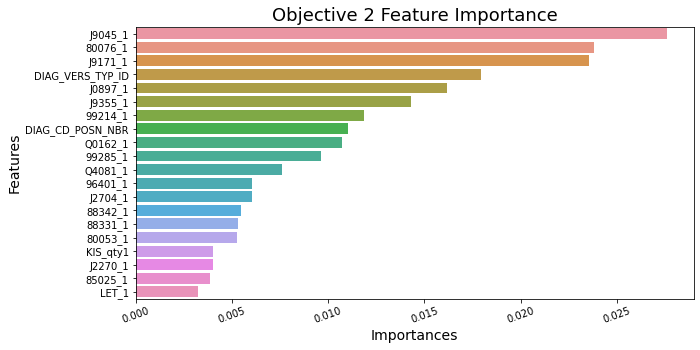

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
fig = sns.barplot(x = feature_imp.iloc[:,1], y=feature_imp.iloc[:,0])
fig = plt.xticks(rotation=20)
fig = plt.xlabel('Importances', fontsize=14)
fig = plt.ylabel('Features', fontsize=14)
fig = plt.title('Objective 2 Feature Importance', fontsize=18)

So, what are these procedures that are so influential?

In [ ]:
# get the table with the descriptions we need 
procedure_reference =  pd.read_csv('/content/drive/My Drive/Novartis/PROCEDURE_reference_20200925.txt', sep='|')

def get_procedure_description(code):
  """
  Given the code, return the (code, description) tuple
  """
  return code, procedure_reference.query("PROCEDURE_CODE == {}".format(code))['PROCEDURE_DESCRIPTION'].iloc[0]

In [ ]:
procedure_code_lst = ["'J9045'", "'80076'", "'J9171'", "'J0897'", "'J9355'", "'99214'",
                      "'Q0162'", "'99285'", "'Q4081'", "'96401'", "'J2704'", "'88342'",
                      "'88331'", "'80053'", "'J2270'", "'85025'"
                      ]

description_lst = []
for code in procedure_code_lst:
  description_lst.append(get_procedure_description(code))

description_df = pd.DataFrame(description_lst, columns=['procedure_code', 'description'])  
description_df = description_df.replace("'", '', regex=True)

description_df

,procedure_code,description
0,J9045,"INJECTION, CARBOPLATIN, 50 MG"
1,80076,HEPATIC FUNCTION PANEL THIS PANEL MUST INCLUDE...
2,J9171,"INJECTION, DOCETAXEL, 1 MG"
3,J0897,"INJECTION, DENOSUMAB, 1 MG"
4,J9355,"INJECTION, TRASTUZUMAB, EXCLUDES BIOSIMILAR, 1..."
5,99214,OFFICE OR OTHER OUTPATIENT VISIT FOR THE EVALU...
6,Q0162,"ONDANSETRON 1 MG, ORAL, FDA APPROVED PRESCRIPT..."
7,99285,EMERGENCY DEPARTMENT VISIT FOR THE EVALUATION ...
8,Q4081,"INJECTION, EPOETIN ALFA, 100 UNITS (FOR ESRD O..."
9,96401,"CHEMOTHERAPY ADMINISTRATION, SUBCUTANEOUS OR I..."
